In [3]:
import torch
import numpy as np
import scipy

from tqdm.auto import tqdm

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets import CelebA
from torchvision.models import inception_v3


from torch import nn
from torch.utils.data import DataLoader
from torch.utils import data
from torch.distributions import MultivariateNormal

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import os
import sys


In [4]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
       
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)


def get_noise(n_samples, z_dim, device='cpu'):
    # n_samples - no of samples to generate
    # z_dim - dim of the noise vector
    
    return torch.randn(n_samples, z_dim, device=device)

In [5]:
z_dim = 64
image_size = 299 # for Inception V3
device = 'cpu'

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # applied to each channel seperately
    ]
)

data_dir = '/home/jerlshin/Documents/My_Work/__DATASET__/CelebA'

dataset = ImageFolder(root=data_dir, transform=transform)

num_samples = 1000
sub_dataset = data.Subset(dataset, range(num_samples))

In [6]:

gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f'../../C1 Build Basic GAN - 26 hrs/W4 Conditional GAN and Controllable Generation/Model_CGAN/pretrained_celeba.pth', map_location=torch.device(device=device))["gen"])

<All keys matched successfully>

### Inception V3 Network

In [12]:
inception_model = inception_v3(pretrained=True)

In [13]:
# inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device=device)
# evaluating mode
inception_model = inception_model.eval()

## Frechet Inception Distance (FID) 

For evalution of the GAN

In [14]:
# Replace the FC layer with an identity function layer to cut off the classification layer and get a feature extractor
inception_model.fc = torch.nn.Identity()
# By replacing it with an identity layer, you effectively remove the classification head, turning the model into a feature extractor. This modified model can be used to extract features from images without making any class predictions.

Frechet Distance

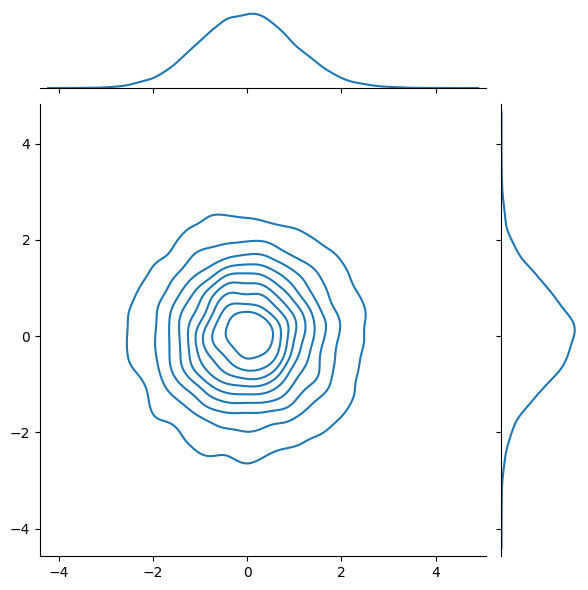

In [15]:
mean = torch.Tensor([0, 0])  # Center the mean at the origin
covariance = torch.Tensor(
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,)) # generates 10000 random samples from multivariate normal distribution
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

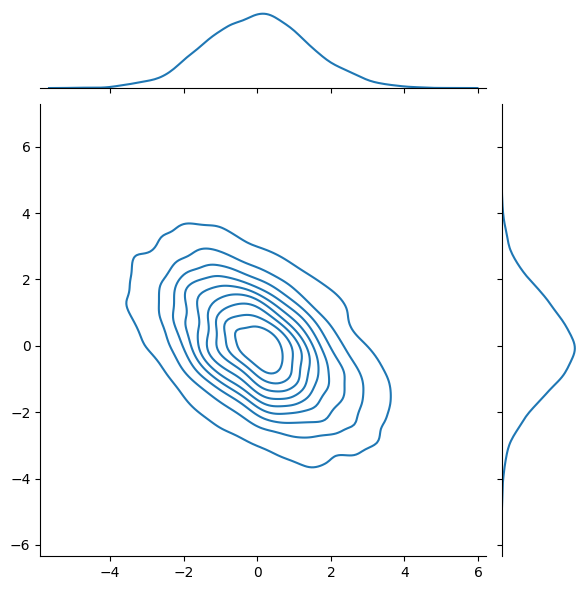

In [16]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(x = samples[:, 0], y =samples[:, 1], kind="kde")
plt.show()

In [17]:
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    
    return torch.Tensor(y.real, device=x.device)

In [18]:
def fretech_distance(mu_x, mu_y, sigma_x, sigma_y):
    return torch.square(torch.norm(mu_x - mu_y)) + torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))


Preprocess the image for the inception-v3 net

In [19]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [20]:
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [21]:
fake_features_list = []
real_features_list = []

gen.eval()

n_samples = 512  # total no of samples
batch_size = 4 # Samples per iteration

# loading the celebA dataset
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

cur_samples = 0
with torch.no_grad(): # no need to calculate gradients here - to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # go by batch by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') 
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)

            cur_samples += len(real_samples)
            
            if cur_samples > n_samples:
                break
    except:
        print("Could not execute")

  0%|          | 0/128 [00:00<?, ?it/s]

In [66]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

Calculating the covariance and means fo the real and fake features

In [67]:
mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)

sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [68]:
assert tuple(sigma_fake.shape) == (fake_features_all.shape[1], fake_features_all.shape[1])
assert tuple(sigma_real.shape) == (real_features_all.shape[1], real_features_all.shape[1])
assert tuple(mu_fake.shape) == (fake_features_all.shape[1],)
assert tuple(mu_real.shape) == (real_features_all.shape[1],)
print("Success!")

Success!


/home/jerlshin/env_ai/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


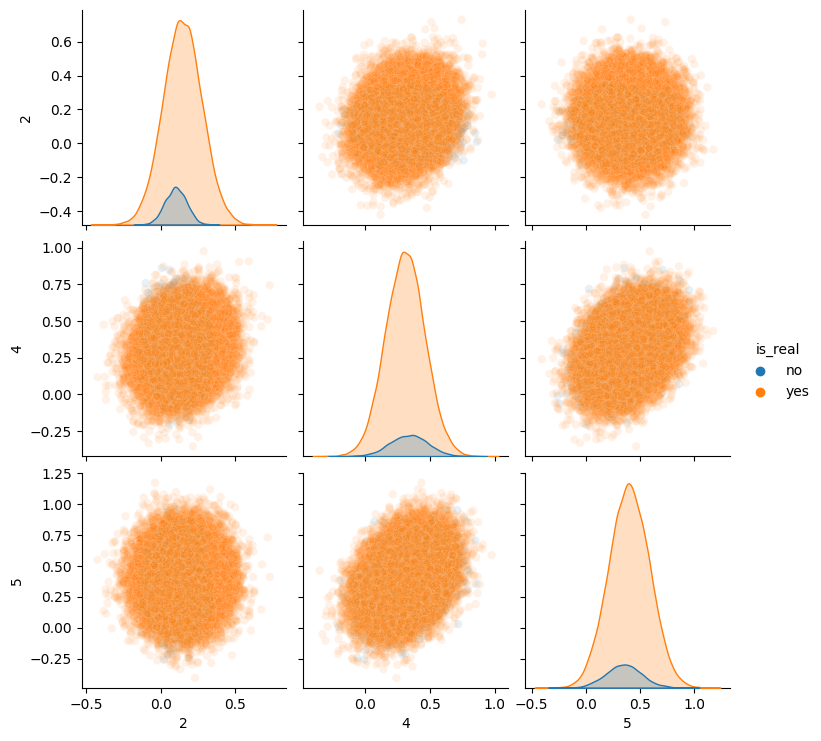

In [69]:
# Visualize the pairwise multivariate distributions of the inception features

indices = [2, 4, 5]

fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000, ))

real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((50000, ))

df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)

df_fake["is_real"] = "no"
df_real["is_real"] = "yes"

df = pd.concat([df_fake, df_real])

sns.pairplot(data=df, plot_kws={'alpha': 0.1}, hue='is_real')

plt.show()      

# what is numel 

In [70]:
with torch.no_grad():
    print(fretech_distance(mu_real, mu_fake, sigma_real, sigma_real).item())

59.79035568237305
